<a href="https://colab.research.google.com/github/mkorlyakova/DataScienceBusiness/blob/master/Unet_background_first_line.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ответы  на запрос "товары на полке распознать":

https://www.datanomics.ru/artciles/raspoznavanie-tovara-na-polke/

https://habr.com/ru/company/true_engineering/blog/416123/




# Инсталяция рабочих пакетов

мой GITHub репозиторий для подключения картинок

In [1]:
# Clone the entire repo.
#
#!git clone https://github.com/mkorlyakova/test_pallet.git
#!ls

Библиотека для чтения архива

In [2]:
!pip install rarfile

Импорт модулей:
 - общие : numpy
 - обработка файлов : glob, libarchive, os
 - чтение и разбор данных : json, cv2, shapely.geometry
 - отрисовка графиков : matplotlib
 - обучение : sklearn, tensorflow
 

In [3]:
import numpy as np
import pandas as pd
from glob import glob
#import libarchive

#import libarchive.public
import rarfile
import os


import json

import cv2 as cv
import matplotlib.pyplot as plt

In [4]:
from shapely.geometry import Polygon

In [5]:
from sklearn.cluster import DBSCAN
# кластеранализ


In [6]:
import tensorflow as tf




Время:
 - 21.04: 18:40 -19:10, 19:40 - 21:00, 22:00-0:00  : итого 4 часа 
 - 22.04: 10:45 - 11:30, 13:00 - 14:30, 15:00 - 16:30 : итого 3.75 часа


In [7]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


## Подключение и чтение информации

Задаю пути к рабочим каталогам

In [8]:
# отсюда берем архив
path = '/gdrive/MyDrive/Разметка фона/Переразметка фонов (вода).rar'

In [9]:
# тут распакум данные
path_image = '/content/image_json/'

## Читаем и распаковываем

In [10]:

def extractrar(loc,outloc, numb= 100):
        '''
        using the rarfile tool extract here .
        this function is valid if the file type is rar only
        '''
        #check the file is rar or not
        if(rarfile.is_rarfile(loc)):
            with rarfile.RarFile(loc,"r") as rar_ref:
                    # iterate over zip info list.
                    for item in rar_ref.infolist():
                        rar_ref.extract(item,outloc)
                    # once extraction is complete
                    # get the name of the rar files inside the rar.
                    rar_files = [file for file in rar_ref.infolist() if file.filename.endswith('.rar') ]
                    # iterate
                    k = 0
                    for file in rar_files:
                        # iterate to get the name.
                        new_loc = os.path.join(outloc,file.filename)
                        #new location
                        # print(new_loc)
                        #start extarction.
                        check_archrive_file(new_loc)
                        if k> numb:
                          break
                    # close.
                    rar_ref.close()
        else:
            print("File "+loc+" is not a rar file")

In [11]:
extractrar(path,path_image, numb= 10)

In [12]:
path_image = '/content/image_json/ВОДА(разметка товара)/background/data'

Списки файлов аннотаций и изображений отдельно:

In [13]:
json_arr = glob(path_image+'/*.json')  # список имен аннотаций
jpeg_arr = glob(path_image+'/*.jpg')  # список имен картинок
print('число аннотаций :',len(json_arr))
print('число картинок :',len(jpeg_arr))

число аннотаций : 750
число картинок : 676


Потеряшки!


Проверим разметку.

In [14]:
# визуализация рамки
def rect(img, boundBox, text="", colors_ = (255,255,255), thick = 20):
  '''
  Рисуем рамку на изображении img (по OpenCV2), 
  boundBox - углы рамка (X,Y левого верхнего угла,  X, Y правого нижнего угла), 
  text="" - текст для рамки, 
  colors_ = (255,255,255) - цвет для рамки, 
  thick = 20 -  толщина рамки или если (-1), то рисуем сплошную залитую рпамку
  '''
  x1r,y1r,x2r,y2r = boundBox  # читаем координаты углов
  # размер изображения
  s = img.shape
  # координаты в целые
  x1 = int(np.ceil(x1r)) 
  y1 = int(np.ceil(y1r))
  x2 = int(np.ceil(x2r)) 
  y2 = int(np.ceil(y2r))
  #print(x1,y1,x2,y2)
  #print(colors_)
  # рамка
  cv.rectangle(img, (x1,y1), (x1+x2,y1+y2), colors_, thick)
  # текст рамки
  l = 0
  if text != "":
    l = len(text)*14
  cv.rectangle(img,(x1,y1-22),(x1+l,y1),colors_,-1)
  font = cv.FONT_HERSHEY_SIMPLEX
  cv.putText(img,text,(x1,y1), font, 0.8,(0,0,0),1,cv.LINE_AA)
  #return img

Посмотрим на разметку по аннотации

In [29]:
def annotation_read(image_name, json_arr):
  '''
  поиск и чтение аннотаций
  image_name - имя картинки, 
  json_arr - список имен файлов аннотаций

  вернем: список списков координат рамок box_bound

  '''
  k = json_arr.index(image_name+'.json')
                       
  print('картинка : ',json_arr[k])
  # читаем картинку
  image = cv.imread(image_name)
  image_shape.append(image.shape)
  # читаем аннотацию
  box_bound =[]
  with open(json_arr[k]) as f:
    decoded_hand = json.load(f)
    #print(decoded_hand)
    for to_do in decoded_hand['objects']:
      b_box = to_do['bbox']
      #print(b_box)
      b_box = b_box.split(', ')
      box_bound.append([int(x) for x in b_box])
    #print(box_bound)
    print('число рамок на картинке: ',len(box_bound))
  return  box_bound, image

картинка :  /content/image_json/ВОДА(разметка товара)/background/data/2bf07e52227f4437a03b02ce6e3a5399.jpg.json
число рамок на картинке:  19


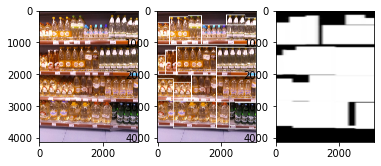

картинка :  /content/image_json/ВОДА(разметка товара)/background/data/28155a56ff8748099870a947e98f1453.jpg.json
число рамок на картинке:  10


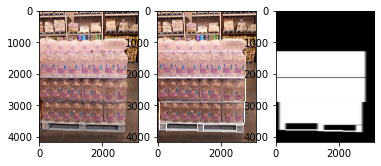

размер по У: минимальный =  4128   : максимальный  =  4160
размер по х: минимальный =  3096   : максимальный  =  3120
число каналов:   3
число объектов на картинках: минимальный =  10   : максимальный  =  19   : средний : 14.5


In [30]:
image_shape = []
numb_bound = []


def image_seg_read(image_name='',json_arr=json_arr,numb_bound=[], thick = 10, verbose = 0):


  
  # картинке ставим в соответствие аннотацию
  box_bound, image = annotation_read(image_name, json_arr)
  numb_bound.append(len(box_bound))
  if verbose:
    plt.subplot(1,3,1)
    plt.imshow(image)
  
  seg_image =  image.copy()
  seg_image[:,:,:] = 0 # np.zeros(shape = (image.shape[0],image.shape[1],3), np.uint8)
  image_orig = image.copy()
  # по всем рамкам из аннотации
  for i_box in box_bound:
    # строим рамку на картинку
    #image = 
    rect(image,i_box,'', thick = 20)
    #seg_image = 
    rect(seg_image,i_box,'', thick = thick)
    s = 100
    seg_image = cv.resize(seg_image, (int(image.shape[1]/s),int(image.shape[0]/10)), cv.INTER_NEAREST)
    seg_image = cv.resize(seg_image, (image.shape[1],image.shape[0]), cv.INTER_LINEAR)
  # выводим
  if verbose:
    plt.subplot(1,3,2)
    plt.imshow(image)
    #
    plt.subplot(1,3,3)
    plt.imshow(seg_image)
  
    plt.show()
  return image, seg_image/255 , numb_bound, image_orig
# собрали размеры картинок    


batch_read = 2
# листаем список имен файлов картинок
for image_name in jpeg_arr[:batch_read]:
  image, seg_image, numb_bound, _ = image_seg_read(image_name=image_name,json_arr=json_arr,numb_bound=numb_bound, thick = -1, verbose = 1)



image_shape = np.array(image_shape)

# резюме по данным
print('размер по У: минимальный = ',image_shape[:,0].min(),'  : максимальный  = ', image_shape[:,0].max())
print('размер по х: минимальный = ',image_shape[:,1].min(),'  : максимальный  = ', image_shape[:,1].max())
print('число каналов:  ',image_shape[0,2])
print('число объектов на картинках: минимальный = ',np.min(numb_bound),'  : максимальный  = ', np.max(numb_bound), '  : средний :',np.mean(numb_bound))
                  

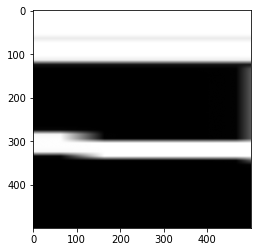

In [17]:
    plt.imshow(seg_image[3500:4000,2000:2500,:])
  
    plt.show()

In [18]:
from tensorflow.keras.utils import Sequence



class CustomDataGen(Sequence):
  
  
  def __init__(self, 
               batch_size,
               path_image_dir='',
               jpeg_arr = [],
               json_arr = [],
               input_size=(128, 128, 3),
               s = 100,
               W = 256,
               shuffle=True):
    self.path_image = path_image_dir
    self.batch_size = batch_size
    self.input_size = input_size
    self.shuffle = shuffle
    self.s = s
    self.W = W
        
        
    self.json_arr = json_arr
    self.jpeg_arr = jpeg_arr
    self.n = len(self.jpeg_arr)
  
  def annotation_read_(self, image_name = ''):
    k = self.json_arr.index(image_name+'.json')
    
    # читаем картинку
    image = cv.imread(image_name)
  
    # читаем аннотацию
    box_bound =[]
    with open(json_arr[k]) as f:
      decoded_hand = json.load(f)
      #print(decoded_hand)
      for to_do in decoded_hand['objects']:
        b_box = to_do['bbox']
        b_box = b_box.split(', ')
        box_bound.append([int(x) for x in b_box])

    return  box_bound, image    
    
  def on_epoch_end(self):
    pass
    
  def __getitem__(self, index):
    box_bound, image = self.annotation_read_(self.jpeg_arr[index])
    seg_image =  image.copy()
    seg_image[:,:,:] = 0 # np.zeros(shape = (image.shape[0],image.shape[1],3), np.uint8)
    img_shape = image.shape

    # по всем рамкам из аннотации
    #print(len(box_bound))
    for i_box in box_bound:
      # строим рамку 
      rect(seg_image,i_box,'', thick = -1)
    
    seg_image = cv.resize(seg_image, (int(float(img_shape[1])/self.s),int(float(img_shape[0])/self.s)), cv.INTER_NEAREST)
    seg_image = cv.resize(seg_image, (img_shape[1],img_shape[0]), cv.INTER_LINEAR)
   
    #вернуть объекты и кадрировать их  
    n_point = 100
    return np.array([image[n_point:n_point+self.W,n_point:n_point+self.W,:]]), np.array([seg_image[n_point:n_point+self.W,n_point:n_point+self.W,:1].astype(float)/255])   
    
  def __len__(self):
    return self.n // self.batch_size

In [19]:
N_split = 50
data_gen = CustomDataGen(4,path_image_dir=path_image,jpeg_arr =jpeg_arr[:-N_split],json_arr=json_arr, W = 256, s=100)
data_gen_test = CustomDataGen(4,path_image_dir=path_image,jpeg_arr =jpeg_arr[-N_split:],json_arr=json_arr, W = 256, s=100)
for i in range(8):
    x,y = data_gen[i]
    if (x.shape[2]<256) | (x.shape[1]<256):
      print(i,':',x.shape,y.shape)
    #plt.subplot(1,2,1)
    #plt.imshow(x[0,:,:,:])
    #plt.subplot(1,2,2)
    #plt.imshow(y[0,:,:,0])
    #plt.show()

In [20]:
y.shape

(1, 256, 256, 1)

# Решение 1
UNet

In [21]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras import backend as K
#
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers  import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [22]:
from tensorflow.python.framework import ops

from tensorflow.python.keras.utils import losses_utils

from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)


def focal(y_true, y_pred):
    alpha = 1
    gamma = 2
    
    num = y_true.shape
    #print(y_true,y_pred)

    
    y_pred = ops.convert_to_tensor_v2_with_dispatch(y_pred)
    y_true = math_ops.cast(y_true, y_pred.dtype)
    BCE_loss = tensorflow.keras.losses.CategoricalCrossentropy()

    return K.mean((y_pred - 1)** gamma * alpha * BCE_loss( y_true, y_pred), axis=-1)

In [23]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

In [26]:
def unet_pre_train(use_pretrain = True, num_classes = 2, input_shape= (128, 128, 3),level = 3,neuron = 16, lr=0.0001,b1 = 0.9, b2=0.9999):  
    img_input = Input(shape = input_shape)
    if use_pretrain :
        # грузим   VGG16
 
        model_vgg16_3 = VGG16(input_tensor = img_input, input_shape = (input_shape[0],input_shape[1],3),include_top=False, weights="imagenet")

            
            
        
        #y = pre_trained_model(x_in) 
        
        # замораживаем все слои
        for layer in model_vgg16_3.layers:
            layer.trainable = False
            
        print('img_input: ',model_vgg16_3.layers)
        
        #y_bloc = [y]
        
        
         
        #print(x_in)
        #y = pre_trained_model.layers[0](x_in )
        #print(y)
        # фиксируем скипы для переноса из VGG16 (надо еще проверять)
        #blocks_ = [ pre_trained_model.layers[2].output]
        blocks_ =[ model_vgg16_3.layers[2].output]
        for i in range(level):
            #blocks_.append( pre_trained_model.layers[5+i*4].output)
            blocks_.append( model_vgg16_3.layers[5+i*4].output)
        #block_3_out = pre_trained_model.layers[6].output
        #block_2_out = pre_trained_model.layers[3].output
        
        #  фиксируем вход сети
        
        
        
        # фиксируем последний рабочий слой для своего потока  
        #x = pre_trained_model.layers[level*4+1].output
        x =  model_vgg16_3.layers[1+level*4].output
        #x = y_bloc[level*4+2]
        #print('y:',y_bloc)
        #print('x:',x)
        
    else:
        #x = Conv2D(3, (3, 3), padding='same')(img_input )
        #pre_trained_model.layers[0].input = x                                      
        #x = pre_trained_model.layers[0].output
        x1 = img_input
        #print(x1)
    
        blocks_ = []
        i = 0
        for i in range(level):
            x2 = Conv2D(neuron*(i+1), (3, 3), padding='same')(x1)
            
            x2 = BatchNormalization()(x2)
            x2 = Activation('relu')(x2)

            x2 = Conv2D(neuron*(i+1), (1, 1), padding='same')(x2)
            x2 = BatchNormalization()(x2)
            x2 = Activation('relu')(x2) 
            
            x3 = Conv2D(neuron*(i+1), (1, 1), padding='same')(x1)
            
            x3 = BatchNormalization()(x3)
            x3 = Activation('relu')(x3)

            x3 = Conv2D(neuron*(i+1), (3, 3), padding='same')(x3)
            x3 = BatchNormalization()(x3)
            x3 = Activation('relu')(x3)
            
            x4 = Conv2D(neuron*(i+1), (5, 5), padding='same')(x1)
            
            x4 = BatchNormalization()(x4)
            x4 = Activation('relu')(x4)

            
            x = concatenate([x2,x3,x4,x1], axis = 3 )
        
            blocks4 = x
            
            blocks_.append(x)
            
    
            # down i
            x = MaxPooling2D(padding='same')(x)
            x1 = x
            print('i: ',i,x)
    
     
    #print('x up:',x)
    x = Conv2D(neuron*(level+1), (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(neuron*(level+1), (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # задаем список скипов
    #print(blocks_)
    #print(x)

    for i in range(level-1,0,-1):
      # UP i
      #print(i,'x up:',x)
      x = Conv2DTranspose(neuron*i, (2, 2), strides=(2, 2), padding='same')(x)
      x = BatchNormalization()(x)
      x = Activation('relu')(x)
        
      x = concatenate([x, blocks_[i]] ) # добавили перенос из понижаюшего плеча 
      x = Conv2D(neuron*i, (3, 3), padding='same')(x)
      x = BatchNormalization()(x)
      x = Activation('relu')(x)

      x = Conv2D(neuron*i, (3, 3), padding='same')(x)
      x = BatchNormalization()(x)
      x = Activation('relu')(x)


    #print(x)
    x = Conv2DTranspose(neuron*i, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    #print(-1+i,'x up:',x)    
    x = concatenate([x, blocks_[0]] ) # добавили перенос из понижаюшего плеча 
    # последний слой сверток для классификации
    x = Conv2D(neuron, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    if num_classes>1:
      x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)
      # собираем модель 
      #print('model:',img_input,x)  
      model = Model(img_input, x)
      model.compile(optimizer=Adam(),
                    loss= 'categorical_crossentropy',#focal, #'
                    metrics=[dice_coef])
    else:
      x = Conv2D(num_classes, (3, 3), activation='sigmoid', padding='same')(x)
      # собираем модель
      #print('model:',img_input,x) 
      model = Model(img_input, x)
      model.compile(optimizer=Adam(learning_rate=lr, beta_1=b1, beta_2=b2),
                    loss = 'mse',
                    metrics=[dice_coef])

    #model.summary()
    # вернем модель
    return model

## Проверка сборки модели

In [ ]:
K.clear_session()
im_size=x[0,:,:,:].shape
model= unet_pre_train(use_pretrain = False,num_classes = 1, input_shape= (im_size[0], im_size[1], im_size[2]), level = 5,neuron = 16)

KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
i:  0 KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 51), dtype=tf.float32, name=None), name='max_pooling2d/MaxPool:0', description="created by layer 'max_pooling2d'")
i:  1 KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 147), dtype=tf.float32, name=None), name='max_pooling2d_1/MaxPool:0', description="created by layer 'max_pooling2d_1'")
i:  2 KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 291), dtype=tf.float32, name=None), name='max_pooling2d_2/MaxPool:0', description="created by layer 'max_pooling2d_2'")
i:  3 KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 483), dtype=tf.float32, name=None), name='max_pooling2d_3/MaxPool:0', description="created by layer 'max_pooling2d_3'")
i:  4 KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 723), dtype=tf.float32, name=None), name='max_pooling2d_4/MaxPool:0', de

In [ ]:
es = EarlyStopping(monitor = ['val_loss'], patience = 4)
modch = ModelCheckpoint(monitor='val_loss',mode='min',save_best_only=True,save_weights_only=True,verbose=1,filepath='model.{epoch:02d}-{val_loss:.2f}.h5')

In [ ]:
history1 = model.fit(data_gen, epochs=10, verbose=1 ,validation_data = data_gen_test)

Epoch 1/10
156/156 [==============================] - 72s 220ms/step - loss: 0.2609 - dice_coef: 0.1354 - val_loss: 0.1314 - val_dice_coef: 0.0830
Epoch 2/10
156/156 [==============================] - 33s 214ms/step - loss: 0.1781 - dice_coef: 0.0913 - val_loss: 0.1258 - val_dice_coef: 0.0948
Epoch 3/10
156/156 [==============================] - 33s 209ms/step - loss: 0.1460 - dice_coef: 0.0992 - val_loss: 0.1121 - val_dice_coef: 0.0896
Epoch 4/10
156/156 [==============================] - 34s 218ms/step - loss: 0.1345 - dice_coef: 0.0882 - val_loss: 0.0856 - val_dice_coef: 0.0690
Epoch 5/10
156/156 [==============================] - 34s 220ms/step - loss: 0.1129 - dice_coef: 0.0787 - val_loss: 0.0851 - val_dice_coef: 0.0714
Epoch 6/10
156/156 [==============================] - 33s 213ms/step - loss: 0.1103 - dice_coef: 0.0682 - val_loss: 0.0830 - val_dice_coef: 0.0680
Epoch 7/10
156/156 [==============================] - 33s 213ms/step - loss: 0.1033 - dice_coef: 0.0647 - val_loss: 0.

In [ ]:
dict_rez=[{'use_pretrain' :0,'num_classes':1, 'input_shape':(im_size[0], im_size[1], im_size[2]), 'level' :5,'neuron': 16, 'epochs':10, 'verbose':1, 'loss':history1.history['loss'][-1], 'val_loss':history1.history['val_loss'][-1] }]
pd_rez = pd.DataFrame(dict_rez)
pd_rez.to_csv('rez.csv')

### **Предсказание** для сборки

In [ ]:
X,Y = data_gen_test[5]

0.49026197  :  0.14187196


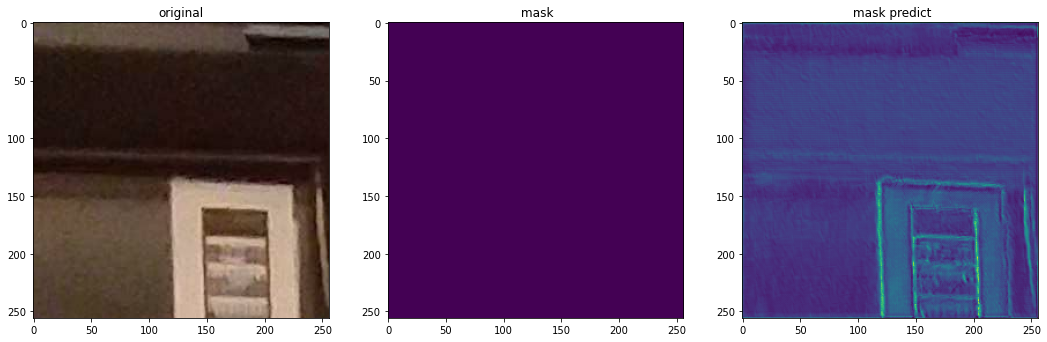

0.4924677  :  0.1623442


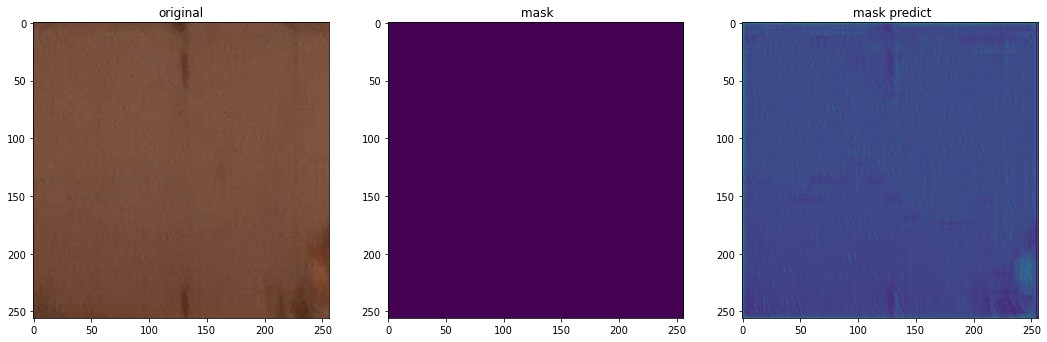

0.46585375  :  0.186531


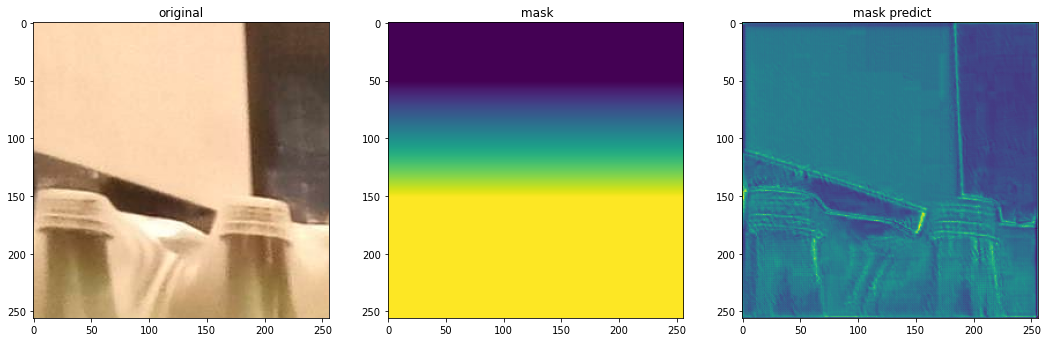

0.39696488  :  0.07390591


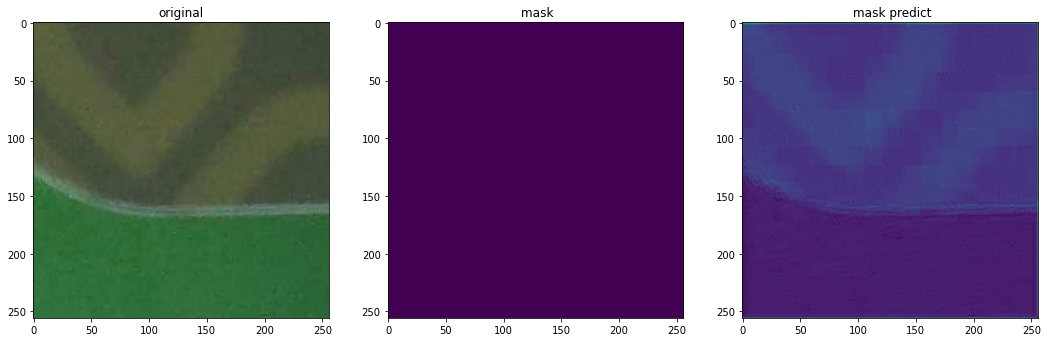

0.5963862  :  0.1917572


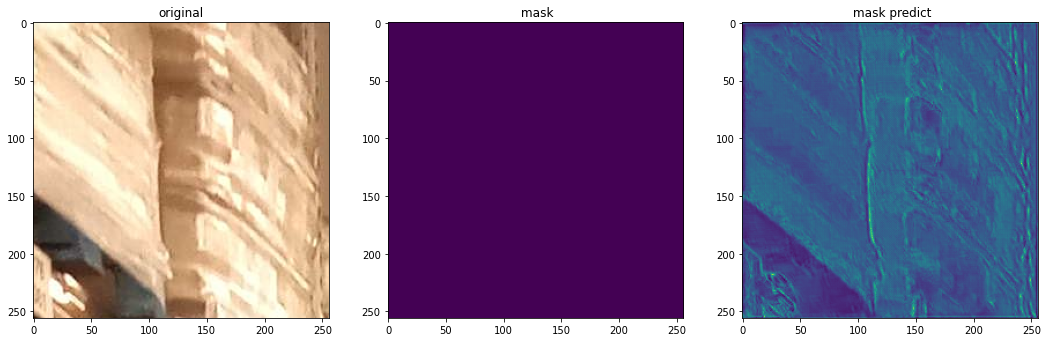

0.59084076  :  0.10402977


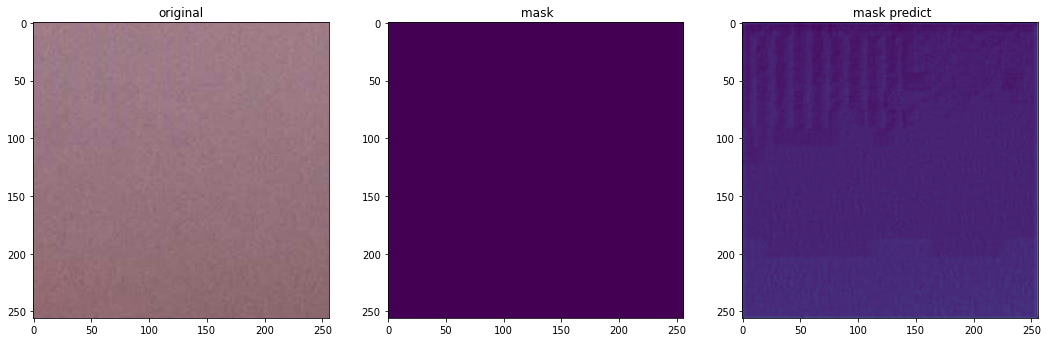

0.4606726  :  0.12377575


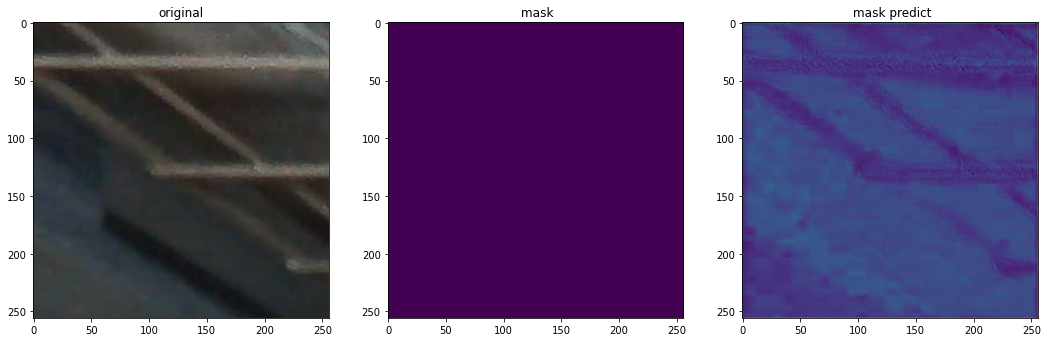

0.534829  :  0.2108646


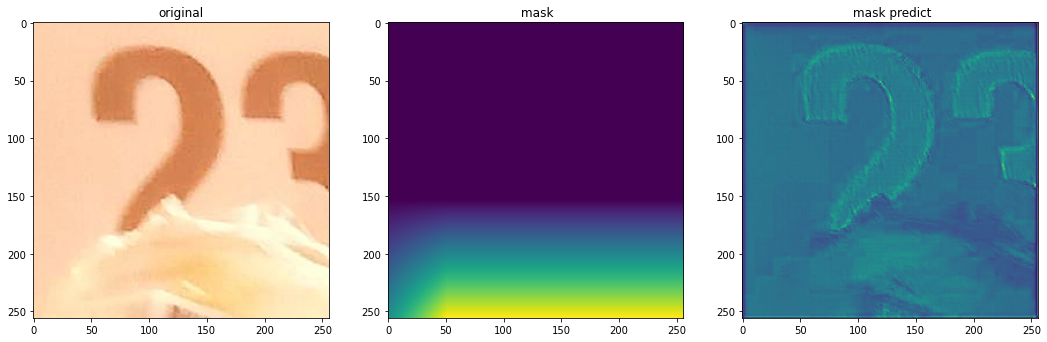

0.53525245  :  0.19623826


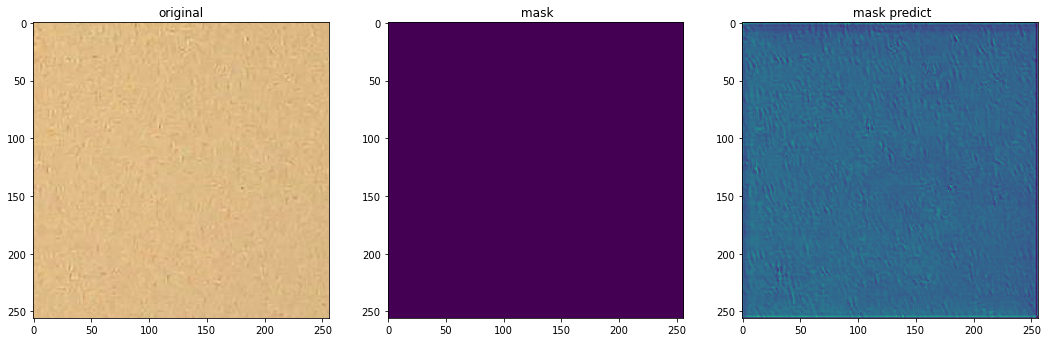

0.54089993  :  0.22489998


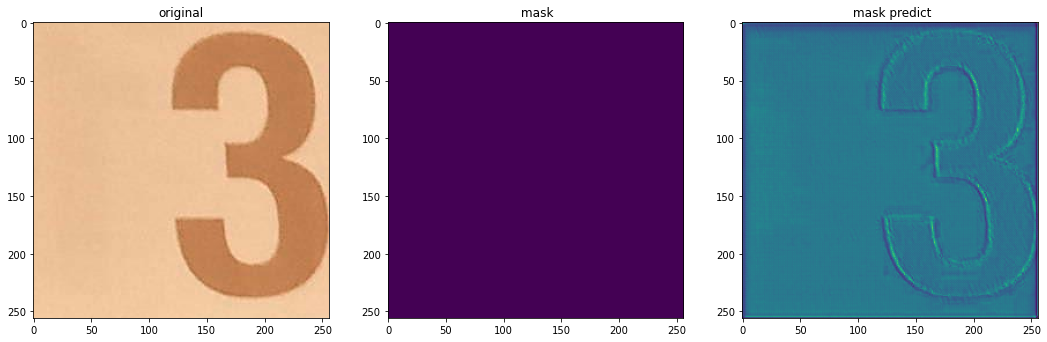

In [ ]:


n = 0

chanel = 0
for k in range(10):
  X,Y = data_gen_test[k]
  predictedt = model.predict(X)
  fig = plt.figure(figsize = (18,15))

  plt.subplot(1,3,1)
  plt.imshow(X[n][...,:])
  plt.title('original')

  plt.subplot(1,3,2)
  #plt.imshow(Xt[n][...,0], cmap = 'bone')
  plt.imshow(Y[n][...,chanel])
  plt.title(' mask')
  plt.subplot(1,3,3)
  #plt.imshow(Xt[n][...,0], cmap = 'bone')
  plt.imshow(predictedt[n][...,chanel])
  plt.title(' mask predict')
  print((np.max(predictedt[n][...])),' : ',str(np.mean(predictedt[n][...])))
  plt.show()

In [ ]:
from google.colab import files


## **Эксперимент**

Изменяем варианты модели, смотрим на результат без статистики, по одному перезапуску. Параметры для варьирования в эксперименте:
 - число уровней свертки : 2,3 и 4
 - базовое число фильтров: 32,16,8
 - использовать или нет претренированную сетку VGG16

img_input:  [<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f9a5c476e10>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9a704d77d0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9a5c5eb990>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9a5c4a9fd0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9a701ccc50>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9a5c6cd0d0>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9a5c4122d0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9a5c441890>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9a5c3f7210>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9a5c3f7a50>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9a5c433490>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9a5c44d190>, <tensorflow.python.keras.

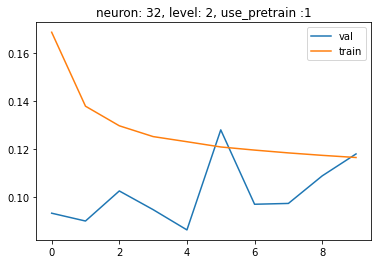

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
i:  0 KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 99), dtype=tf.float32, name=None), name='max_pooling2d/MaxPool:0', description="created by layer 'max_pooling2d'")
i:  1 KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 291), dtype=tf.float32, name=None), name='max_pooling2d_1/MaxPool:0', description="created by layer 'max_pooling2d_1'")
x up: KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 291), dtype=tf.float32, name=None), name='max_pooling2d_1/MaxPool:0', description="created by layer 'max_pooling2d_1'")
[<KerasTensor: shape=(None, 256, 256, 99) dtype=float32 (created by layer 'concatenate')>, <KerasTensor: shape=(None, 128, 128, 291) dtype=float32 (created by layer 'concatenate_1')>]
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 96), dtype=tf.float32, name=None), name='activation_11/Relu:0', descript

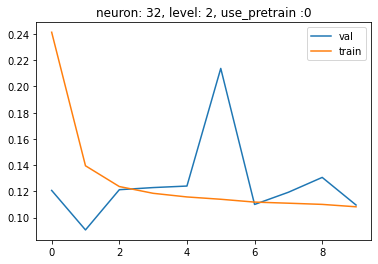

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

img_input:  [<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f9ae6726a10>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9ae6725ed0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9ae6564f50>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9ae655d650>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9ae6158250>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9b43dd7210>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9ae671dfd0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9b43dd7dd0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9ae6385e50>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9a5c202650>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9b43dae4d0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9ae638ff50>, <tensorflow.python.keras.

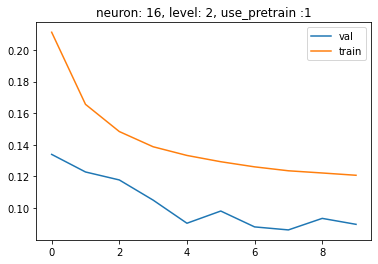

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
i:  0 KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 51), dtype=tf.float32, name=None), name='max_pooling2d/MaxPool:0', description="created by layer 'max_pooling2d'")
i:  1 KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 147), dtype=tf.float32, name=None), name='max_pooling2d_1/MaxPool:0', description="created by layer 'max_pooling2d_1'")
x up: KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 147), dtype=tf.float32, name=None), name='max_pooling2d_1/MaxPool:0', description="created by layer 'max_pooling2d_1'")
[<KerasTensor: shape=(None, 256, 256, 51) dtype=float32 (created by layer 'concatenate')>, <KerasTensor: shape=(None, 128, 128, 147) dtype=float32 (created by layer 'concatenate_1')>]
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 48), dtype=tf.float32, name=None), name='activation_11/Relu:0', descript

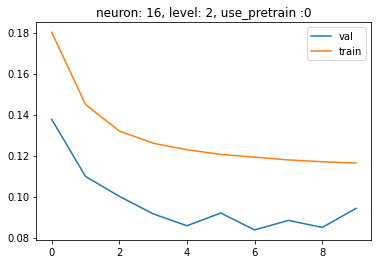

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

img_input:  [<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f9ae6503890>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9b43dcfc90>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9b43daab50>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9a7053d650>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9a5c4a9b90>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9a705c2810>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9a5c4a9c50>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9a705c2550>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9ad1344750>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9ad11ca9d0>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9aee1bcad0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9a5c38b1d0>, <tensorflow.python.keras.

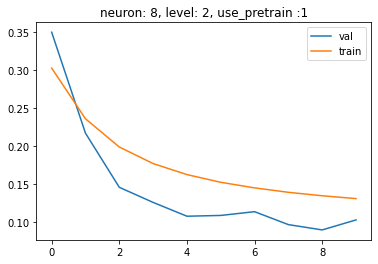

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
i:  0 KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 27), dtype=tf.float32, name=None), name='max_pooling2d/MaxPool:0', description="created by layer 'max_pooling2d'")
i:  1 KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 75), dtype=tf.float32, name=None), name='max_pooling2d_1/MaxPool:0', description="created by layer 'max_pooling2d_1'")
x up: KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 75), dtype=tf.float32, name=None), name='max_pooling2d_1/MaxPool:0', description="created by layer 'max_pooling2d_1'")
[<KerasTensor: shape=(None, 256, 256, 27) dtype=float32 (created by layer 'concatenate')>, <KerasTensor: shape=(None, 128, 128, 75) dtype=float32 (created by layer 'concatenate_1')>]
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 24), dtype=tf.float32, name=None), name='activation_11/Relu:0', description

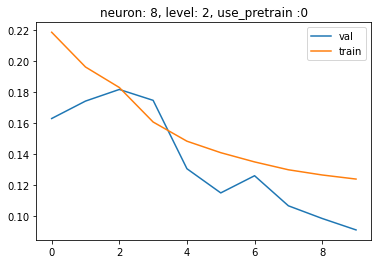

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

img_input:  [<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f9a5c1083d0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9a5c3dc350>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9aee38d650>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9a70423590>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9ae6582e90>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9a5c0f8890>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9a5c0f8dd0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9a5c0f4d90>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9a7043e650>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9a70437bd0>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9a70437310>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9a5c0f8ad0>, <tensorflow.python.keras.

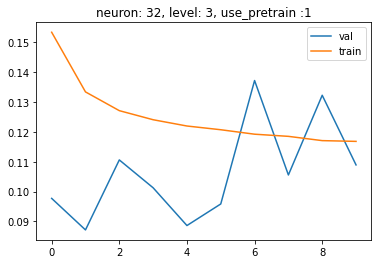

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
i:  0 KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 99), dtype=tf.float32, name=None), name='max_pooling2d/MaxPool:0', description="created by layer 'max_pooling2d'")
i:  1 KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 291), dtype=tf.float32, name=None), name='max_pooling2d_1/MaxPool:0', description="created by layer 'max_pooling2d_1'")
i:  2 KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 579), dtype=tf.float32, name=None), name='max_pooling2d_2/MaxPool:0', description="created by layer 'max_pooling2d_2'")
x up: KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 579), dtype=tf.float32, name=None), name='max_pooling2d_2/MaxPool:0', description="created by layer 'max_pooling2d_2'")
[<KerasTensor: shape=(None, 256, 256, 99) dtype=float32 (created by layer 'concatenate')>, <KerasTensor: shape=(None, 128, 128, 29

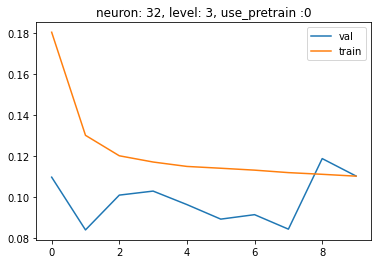

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

img_input:  [<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f9ae61524d0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9aefdf8c90>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9ae6778c90>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9aee3769d0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9b45c8ce10>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9aee345090>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9ae64b0610>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9aee345c10>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9af60d1110>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9af60df650>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9af60dc950>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9aee356a10>, <tensorflow.python.keras.

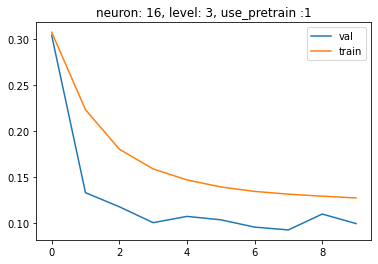

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
i:  0 KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 51), dtype=tf.float32, name=None), name='max_pooling2d/MaxPool:0', description="created by layer 'max_pooling2d'")
i:  1 KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 147), dtype=tf.float32, name=None), name='max_pooling2d_1/MaxPool:0', description="created by layer 'max_pooling2d_1'")
i:  2 KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 291), dtype=tf.float32, name=None), name='max_pooling2d_2/MaxPool:0', description="created by layer 'max_pooling2d_2'")
x up: KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 291), dtype=tf.float32, name=None), name='max_pooling2d_2/MaxPool:0', description="created by layer 'max_pooling2d_2'")
[<KerasTensor: shape=(None, 256, 256, 51) dtype=float32 (created by layer 'concatenate')>, <KerasTensor: shape=(None, 128, 128, 14

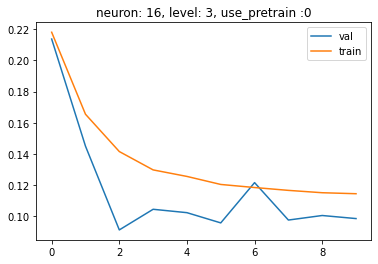

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

img_input:  [<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f9aee0f1f10>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9a5c151490>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9a70205090>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9855782e50>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9a5c1631d0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9855782bd0>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9a5c131390>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9a5c146490>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f985579c290>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9855782ed0>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9855791390>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9855792850>, <tensorflow.python.keras.

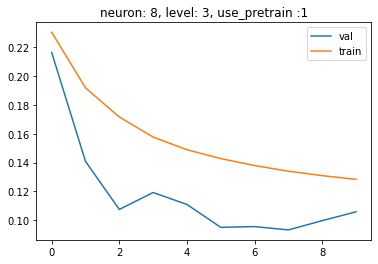

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
i:  0 KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 27), dtype=tf.float32, name=None), name='max_pooling2d/MaxPool:0', description="created by layer 'max_pooling2d'")
i:  1 KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 75), dtype=tf.float32, name=None), name='max_pooling2d_1/MaxPool:0', description="created by layer 'max_pooling2d_1'")
i:  2 KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 147), dtype=tf.float32, name=None), name='max_pooling2d_2/MaxPool:0', description="created by layer 'max_pooling2d_2'")
x up: KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 147), dtype=tf.float32, name=None), name='max_pooling2d_2/MaxPool:0', description="created by layer 'max_pooling2d_2'")
[<KerasTensor: shape=(None, 256, 256, 27) dtype=float32 (created by layer 'concatenate')>, <KerasTensor: shape=(None, 128, 128, 75)

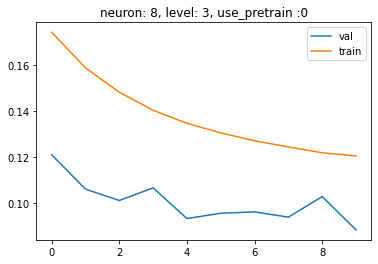

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

img_input:  [<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f9aefdd7310>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9a70208090>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9a701eb5d0>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9a7020a590>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9a701b7310>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9a701f4650>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9a701cfd90>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9a701cfdd0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9b43dcc750>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9b43dbb710>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9b43dc5b10>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9a701cfb50>, <tensorflow.python.keras.

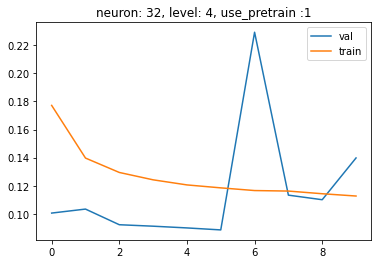

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
i:  0 KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 99), dtype=tf.float32, name=None), name='max_pooling2d/MaxPool:0', description="created by layer 'max_pooling2d'")
i:  1 KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 291), dtype=tf.float32, name=None), name='max_pooling2d_1/MaxPool:0', description="created by layer 'max_pooling2d_1'")
i:  2 KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 579), dtype=tf.float32, name=None), name='max_pooling2d_2/MaxPool:0', description="created by layer 'max_pooling2d_2'")
i:  3 KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 963), dtype=tf.float32, name=None), name='max_pooling2d_3/MaxPool:0', description="created by layer 'max_pooling2d_3'")
x up: KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 963), dtype=tf.float32, name=None), name='max_pooling2d_3/MaxPool:0', 

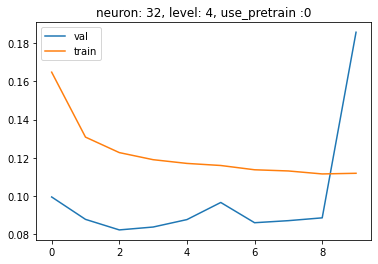

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

img_input:  [<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f9ae6435990>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9ae64d3810>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9ae64be090>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9a5c20a9d0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9a5c2db890>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9aefcb1490>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f98557bae50>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9a70208250>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9a5c1f9650>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9a5c20cf50>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9a5c1f30d0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9a5c20add0>, <tensorflow.python.keras.

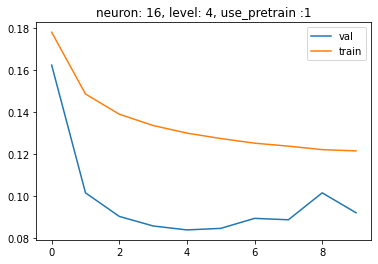

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
i:  0 KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 51), dtype=tf.float32, name=None), name='max_pooling2d/MaxPool:0', description="created by layer 'max_pooling2d'")
i:  1 KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 147), dtype=tf.float32, name=None), name='max_pooling2d_1/MaxPool:0', description="created by layer 'max_pooling2d_1'")
i:  2 KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 291), dtype=tf.float32, name=None), name='max_pooling2d_2/MaxPool:0', description="created by layer 'max_pooling2d_2'")
i:  3 KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 483), dtype=tf.float32, name=None), name='max_pooling2d_3/MaxPool:0', description="created by layer 'max_pooling2d_3'")
x up: KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 483), dtype=tf.float32, name=None), name='max_pooling2d_3/MaxPool:0', 

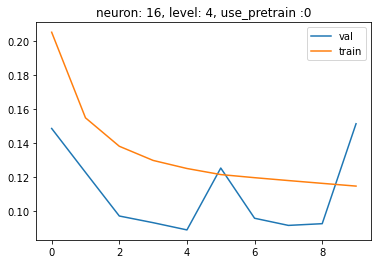

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

img_input:  [<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f9ae64bed50>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9856d5ff50>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f985759ecd0>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9856d02590>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9856d72690>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9856d72410>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9856d15dd0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9856d02350>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9856d21c90>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9856d1bdd0>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9856d153d0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9856d15c90>, <tensorflow.python.keras.

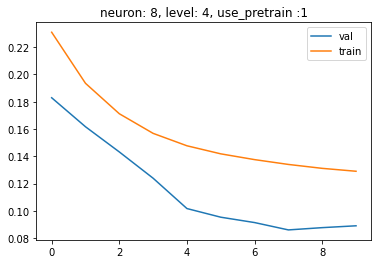

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
i:  0 KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 27), dtype=tf.float32, name=None), name='max_pooling2d/MaxPool:0', description="created by layer 'max_pooling2d'")
i:  1 KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 75), dtype=tf.float32, name=None), name='max_pooling2d_1/MaxPool:0', description="created by layer 'max_pooling2d_1'")
i:  2 KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 147), dtype=tf.float32, name=None), name='max_pooling2d_2/MaxPool:0', description="created by layer 'max_pooling2d_2'")
i:  3 KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 243), dtype=tf.float32, name=None), name='max_pooling2d_3/MaxPool:0', description="created by layer 'max_pooling2d_3'")
x up: KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 243), dtype=tf.float32, name=None), name='max_pooling2d_3/MaxPool:0', d

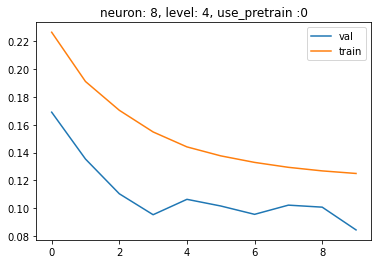

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

img_input:  [<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f9b45be7ed0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9aee36e210>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f98557a3ad0>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9a5c225d90>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9ae66cb750>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9a7031ef10>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9aee36c310>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9aee36c550>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9a70326e10>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9a7034a850>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9a7034a0d0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9aee36c4d0>, <tensorflow.python.keras.

IndexError: ignored

In [ ]:


im_size=x[0,:,:,:].shape
dict_rez = []

for level in [2,3,4]:
  for neuron in [32,16,8]:
    for use_pretrain in [1,0]:
      K.clear_session()
      model= unet_pre_train(use_pretrain = use_pretrain,num_classes = 1, input_shape= (im_size[0], im_size[1], im_size[2]), level = level,neuron = neuron)
      history1 = model.fit(data_gen, epochs=10, verbose=0 ,validation_data = data_gen_test)
      plt.plot(history1.history['val_loss'], label = 'val')
      plt.plot(history1.history['loss'], label = 'train')
      plt.legend()
      plt.title('neuron: '+str(neuron)+ ', level: '+str(level)+', use_pretrain :'+ str(use_pretrain))
      plt.show()
      dict_rez.append({'use_pretrain' :use_pretrain,'num_classes':1, 'input_shape':(im_size[0], im_size[1], im_size[2]), 'level' :level,'neuron': neuron, 'epochs':10, 'verbose':1, 'loss':history1.history['loss'][-1], 'val_loss':history1.history['val_loss'][-1] })
      pd_rez = pd.DataFrame(dict_rez)
      pd_rez.to_csv('rez.csv')
      files.download('rez.csv')




## Результаты эксперимента:



In [ ]:
rez = pd.read_csv('rez.csv')
rez.head(17)

Unnamed: 0  use_pretrain  num_classes  ... verbose      loss  val_loss
0            0             1            1  ...       1  0.116551  0.118043
1            1             0            1  ...       1  0.108230  0.109579
2            2             1            1  ...       1  0.120767  0.089772
3            3             0            1  ...       1  0.116314  0.094228
4            4             1            1  ...       1  0.130947  0.102992
5            5             0            1  ...       1  0.124026  0.091237
6            6             1            1  ...       1  0.116808  0.108919
7            7             0            1  ...       1  0.110145  0.110208
8            8             1            1  ...       1  0.126907  0.099045
9            9             0            1  ...       1  0.114557  0.098627
10          10             1            1  ...       1  0.128364  0.105862
11          11             0            1  ...       1  0.120492  0.088206
12          12             1            1  ...       1  0.112640  0.139761
13          13             0            1  ...       1  0.111931  0.185633
14          14             1            1  ...       1  0.121512  0.092024
15          15             0            1  ...       1  0.114892  0.151483
16          16             1            1  ...       1  0.129041  0.089087

[17 rows x 10 columns]

In [ ]:
rez.append( pd.DataFrame( {'use_pretrain' :0,'num_classes':1, 'input_shape':(256,256,3), 'level' :4,'neuron': 8, 'epochs':10, 'verbose':1, 'loss':history1.history['loss'][-1], 'val_loss':history1.history['val_loss'][-1] }))
rez.head(18)

Unnamed: 0  use_pretrain  num_classes  ... verbose      loss  val_loss
0            0             1            1  ...       1  0.116551  0.118043
1            1             0            1  ...       1  0.108230  0.109579
2            2             1            1  ...       1  0.120767  0.089772
3            3             0            1  ...       1  0.116314  0.094228
4            4             1            1  ...       1  0.130947  0.102992
5            5             0            1  ...       1  0.124026  0.091237
6            6             1            1  ...       1  0.116808  0.108919
7            7             0            1  ...       1  0.110145  0.110208
8            8             1            1  ...       1  0.126907  0.099045
9            9             0            1  ...       1  0.114557  0.098627
10          10             1            1  ...       1  0.128364  0.105862
11          11             0            1  ...       1  0.120492  0.088206
12          12             1            1  ...       1  0.112640  0.139761
13          13             0            1  ...       1  0.111931  0.185633
14          14             1            1  ...       1  0.121512  0.092024
15          15             0            1  ...       1  0.114892  0.151483
16          16             1            1  ...       1  0.129041  0.089087
17          17             0            1  ...       1  0.124953  0.084394

[18 rows x 10 columns]

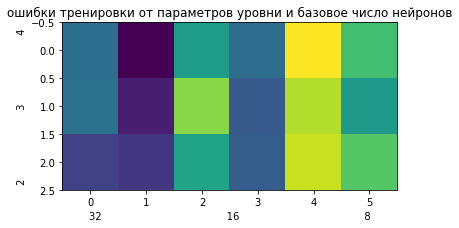

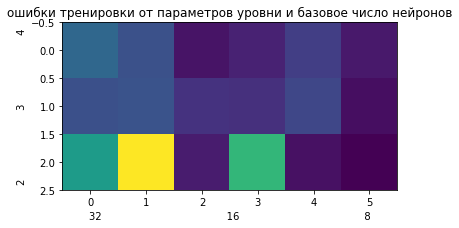

In [ ]:
L_=rez.level.unique()
N_ = rez.neuron.unique()
R_loss = rez.loss.values.reshape(3,6)
R_val_loss = rez.val_loss.values.reshape(3,6)

plt.imshow(R_loss)
plt.xlabel('                                        '.join([str(n) for n in  N_]))
plt.ylabel('                      '.join([str(n) for n in  L_]))
plt.title('ошибки тренировки от параметров уровни и базовое число нейронов')
plt.show()

plt.imshow(R_val_loss)
plt.xlabel('                                        '.join([str(n) for n in  N_]))
plt.ylabel('                      '.join([str(n) for n in  L_]))
plt.title('ошибки теста от параметров уровни и базовое число нейронов')
plt.show()

## **Вывод:**

- меньше базовый размер (беру 8)
- больше число уровней свертки (беру 4)


Обучение модели с лучшим набором:

- use_pretrain = 1,
- num_classes = 1, 
- input_shape= (256, 256, 3), 
- level = 4,
- neuron = 8

In [ ]:
model= unet_pre_train(use_pretrain = 1,num_classes = 1, input_shape= (im_size[0], im_size[1], im_size[2]), level = 4,neuron = 8)
tf.keras.utils.plot_model(model, 'model_8.png')
history1 = model.fit(data_gen, epochs=30, verbose=0 ,validation_data = data_gen_test)

model.save_weights('model.h5')


img_input:  [<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f985491a810>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9aefd2e2d0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f985491c7d0>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9a7035be10>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9aefd0edd0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9af606ff10>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9854939cd0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f985492c9d0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9854929c90>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f98548c0e50>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f98548c6dd0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9af606fc10>, <tensorflow.python.keras.

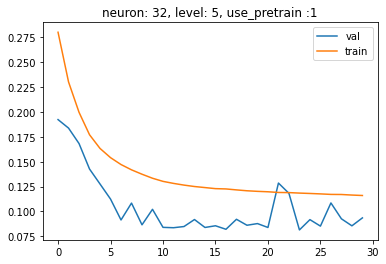

In [ ]:
plt.plot(history1.history['val_loss'], label = 'val')
plt.plot(history1.history['loss'], label = 'train')
plt.legend()
plt.title('neuron: '+str(neuron)+ ', level: '+str(level)+', use_pretrain :'+ str(use_pretrain))
plt.show()

## Тестирование

Сделаем тест для последней картинки:
 - грузим картинку и маску
 - перестраиваю сеть под размер картинки
 - выводим результат предсказания на картинку

картинка :  /content/image_json/ВОДА(разметка товара)/background/data/dce3cd2b429c4b91a87778a2c951c7c5.jpg.json
число рамок на картинке:  32
img_input:  [<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f82404aa350>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f82400d6d50>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f823856fb50>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f823856fdd0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f824093bb90>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8248152910>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f8299cc4050>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8248152210>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f82403d6790>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8299e61110>, <tensorflow.python.keras.layers.pooling.MaxP

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


0.9666463  :  0.08090058


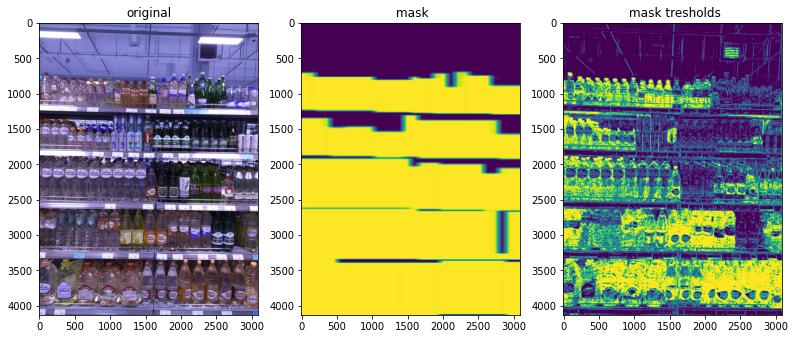

картинка :  /content/image_json/ВОДА(разметка товара)/background/data/470c42904b804b10816453621f0414b3.jpg.json
число рамок на картинке:  19
img_input:  [<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f82408ba090>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f824141f090>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8241576e10>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f8299e29450>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8299e29c50>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8241faea90>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f82408ed110>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f82404fbc50>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8299f056d0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f829bc33410>, <tensorflow.python.keras.layers.pooling.MaxP

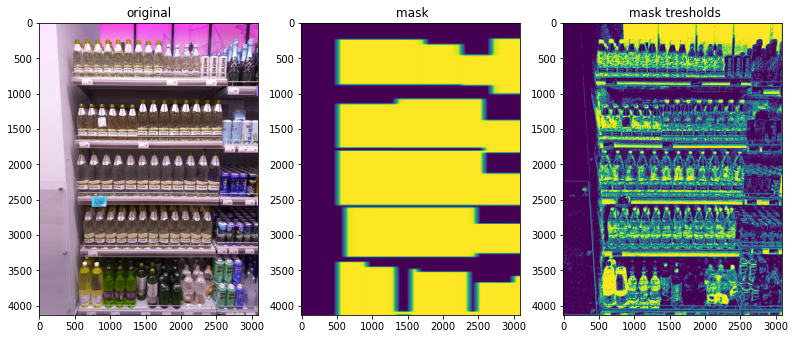

картинка :  /content/image_json/ВОДА(разметка товара)/background/data/3ced245bed634cc0ad90f013fd15e03c.jpg.json
число рамок на картинке:  10
img_input:  [<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f8299f05750>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8299e17d50>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8299dd6610>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f8240383210>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8241576ad0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f824093c910>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f824012af50>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f824038fd90>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8240904bd0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8240387990>, <tensorflow.python.keras.layers.pooling.MaxP

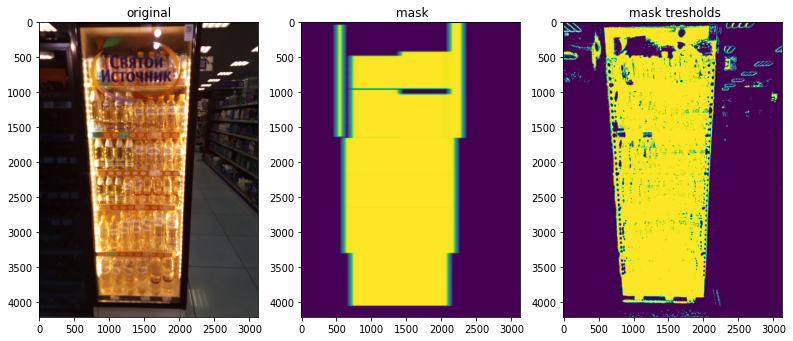

картинка :  /content/image_json/ВОДА(разметка товара)/background/data/6641f981b13042c18ca2884549a85440.jpg.json
число рамок на картинке:  22
img_input:  [<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f8240387a10>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8240300810>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8240107710>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f824092d9d0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f82414f5250>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f82414f5cd0>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f8241ee4090>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8248046390>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8241eeb690>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8248086350>, <tensorflow.python.keras.layers.pooling.MaxP

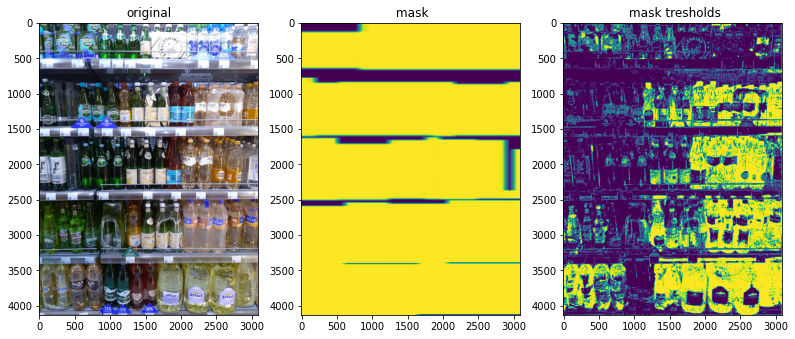

картинка :  /content/image_json/ВОДА(разметка товара)/background/data/bc3b2d497681465284bee68087ed72c8.jpg.json
число рамок на картинке:  14
img_input:  [<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f8241f41610>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8248065c90>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8299e13e90>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f823860ea90>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8240451d10>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f823858ae10>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f8299daaa50>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8241f4cbd0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8299ead810>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f824090f610>, <tensorflow.python.keras.layers.pooling.MaxP

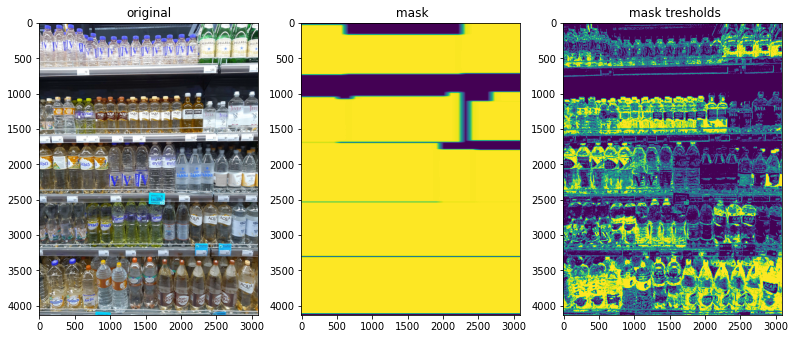

картинка :  /content/image_json/ВОДА(разметка товара)/background/data/80817b31d30b493a82293a278ddf3ccb.jpg.json
число рамок на картинке:  20
img_input:  [<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f8240155810>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8299e618d0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f823856fd90>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f8240383e10>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8241e4c810>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f82403d6c50>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f824042a850>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8240045c90>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f824041f910>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8240933dd0>, <tensorflow.python.keras.layers.pooling.MaxP

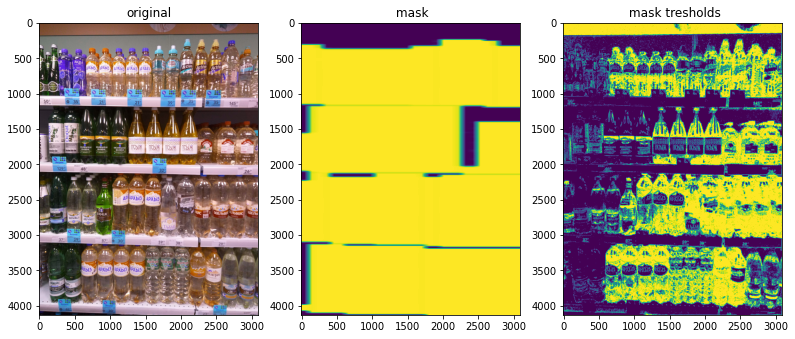

картинка :  /content/image_json/ВОДА(разметка товара)/background/data/deedecd6e7514dcf996d8fafa7c95b3e.jpg.json
число рамок на картинке:  24
img_input:  [<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f8295670f50>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f824098e2d0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8241243610>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f8240696350>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8299c4d050>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f824157ad90>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f8241f91450>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f824157a150>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8299ef3f10>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f824057d890>, <tensorflow.python.keras.layers.pooling.MaxP

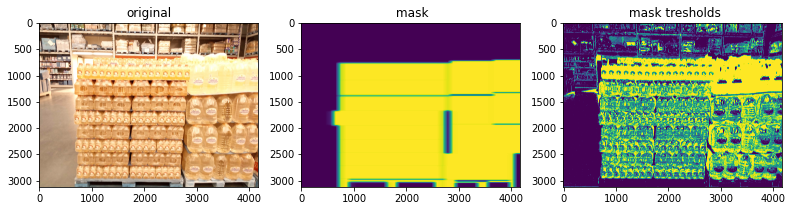

картинка :  /content/image_json/ВОДА(разметка товара)/background/data/31c25a8c194346dea7fb91ef33f944f8.jpg.json
число рамок на картинке:  17
img_input:  [<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f829bcf3f90>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f82402f8ed0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8240303810>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f82402bfed0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8240423f50>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f824017cd50>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f824017c250>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f82402fb150>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8240146f90>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f824014f190>, <tensorflow.python.keras.layers.pooling.MaxP

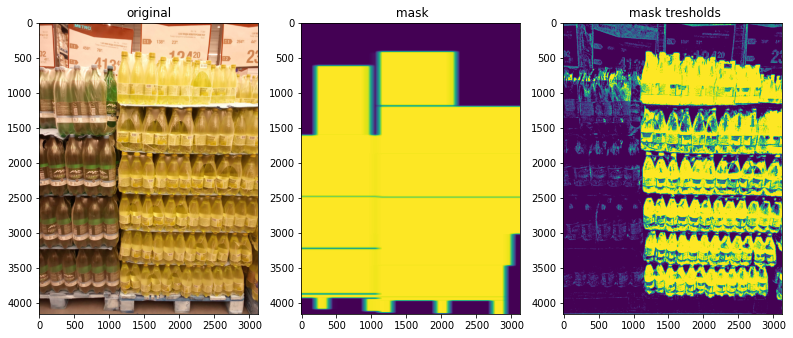

картинка :  /content/image_json/ВОДА(разметка товара)/background/data/2ed62459660e40cc93fe79661fa57301.jpg.json
число рамок на картинке:  6
img_input:  [<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f82480deb10>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f824150bf90>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f82414083d0>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f8241477ad0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f823862ffd0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8241408dd0>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f8240938e10>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8299e5eb10>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f82480ac710>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8241f41c90>, <tensorflow.python.keras.layers.pooling.MaxPo

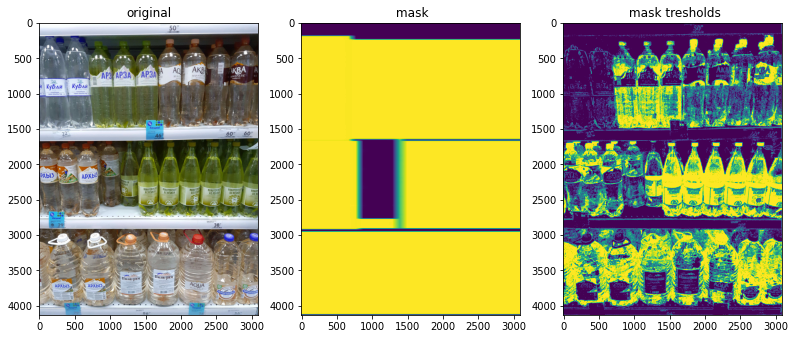

картинка :  /content/image_json/ВОДА(разметка товара)/background/data/ea87b80c192f49f78eb4ac464d82bd21.jpg.json
число рамок на картинке:  11
img_input:  [<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f824090a510>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8241fcb890>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f829bc5cb90>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f82480900d0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f82386398d0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f829d649590>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f823860f710>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f82385a9a10>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8238639d10>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8241ec1810>, <tensorflow.python.keras.layers.pooling.MaxP

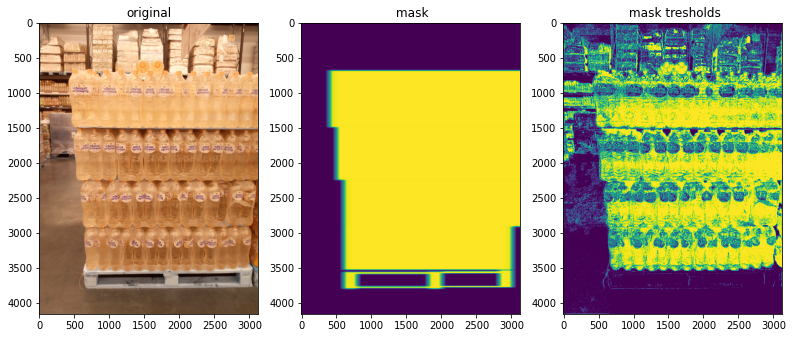

In [34]:
image_shape =[]

def crop_image(I,S, level):
  factor = 2 ** level
  im_size = list(I.shape)

  s1 = (I.shape[0] // factor) * factor
  s2 = (I.shape[1] // factor) * factor
  im_size[0] = s1
  im_size[1]= s2 
  return im_size, I[:s1,:s2,:], S[:s1,:s2,:]

for i in range(-10,0,1):
  image_name = jpeg_arr[i]
  image, seg_image, numb_bound, image_orig = image_seg_read(image_name=image_name,json_arr=json_arr,numb_bound=numb_bound, thick = -1, verbose = 0)

  level = 4
  im_size, image_orig,seg_image = crop_image(image_orig,seg_image, level)



  model= unet_pre_train(use_pretrain = 1,num_classes = 1, input_shape= (im_size[0], im_size[1], im_size[2]), level = level,neuron = 8)
  model.load_weights('model.h5')
  X =np.array([image_orig])
  Y = np.array([seg_image])
  predicted= model.predict(X)
  n=0
  chanel = 0
  fig = plt.figure(figsize = (18,15))

  plt.subplot(1,4,1)
  plt.imshow(X[n][...,:])
  plt.title('original')

  plt.subplot(1,4,2)
  #plt.imshow(Xt[n][...,0], cmap = 'bone')
  plt.imshow(Y[n][...,chanel])
  plt.title(' mask')
  plt.subplot(1,4,3)
  #plt.imshow(Xt[n][...,0], cmap = 'bone')
  plt.imshow(predicted[n][...,chanel])
  plt.title(' mask predict')
  plt.subplot(1,4,3)
  #plt.imshow(Xt[n][...,0], cmap = 'bone')
  plt.imshow(predicted[n][...,chanel]>np.mean(predicted[n][...]))
  plt.title(' mask tresholds') 

  print((np.max(predicted[n][...])),' : ',str(np.mean(predicted[n][...])))
  plt.show()




## Результат 22/04/21

сравнительно прилично :
- нужно сделать слияние областей (вероятно передний план должен быть слитным?)
- нужно взять другие сетки на левое плечо UNet

